## Principal Component Analysis (PCA)
___

1. [Introduction](#1.-Introduction) <br><br>
2. [Synthetic data creation](#2.-Synthetic-data-creation) <br>
    2.1 [Generate data](#2.1.-Generate-data) <br>
    2.2 [Compute the data's mean and covariance matrix](#2.2-Compute-the-data's-mean-and-covariance-matrix) <br><br>

3. [Synthetic data creation](#2.-Synthetic-data-creation)<br>
    3.1. [Variance maximization formulation](#3.-Variance-maximization-formulation)<br>
    3.2. [Defining function to be optimized](#3.1-Defining-function-to-be-optimized)<br>
    3.3. [Plotting the data, along with its principal components](#3.3-Plotting-the-data,-along-with-its-principal-components)<br>
    3.4. [Project the data onto the first principal component](#3.4-Project-the-data-onto-u1,-compute-the-variance-and-plot) <br>
    3.5. [[Extra] Plot the variance against different vector directions](3.4-[Extra]-Plot-the-variance-against-different--vector-directions)<br><br>
    
4. [References](#4.-References)<br>
___

### 1. Introduction

The theory and implementations explored here are based on the 12th chapter of [1]. 

PCA, also known as the *Karhunen-Loève* trasnform, is a technique widely used for applications such as:
- Dimensionality reduction
- Lossy data compression
- Feature extraction
- Data visualization


There are **2** commonly used equivalent definitions of PCA that give rise to the same algorithm:

1. The orthogonal projection of the data onto a lower dimensional linear space (the principal subspace), **maximizing the variance** of the projected data.

2. The linear projection that **minimizes the average projection error**, i.e. the mean squared distance between the data points and their projections. 

Both definitions will be considered, but let's create some synthetic data first! 
___

### 2. Synthetic data creation

Consider a data set of observations $\{\texttt{x}_n\}$ where $n = 1, . . . , N$, and $x_n$ is a
Euclidean variable with dimensionality D. We want to project the data onto a
subspace with dimensionality M < D, maximizing the variance of the projected
data.

In our example, let's have a data set of $n$ 2D random points ($D = 2$) which we want to project onto an 1D-subspace ($M = 1$).

#### 2.1. Generate data

In [22]:
import numpy as np
import matplotlib.pyplot as plt

n = 200                 # Number of points
mean = [4,3]            # Mean
cov  = [[0.40, 0.45],   # Covariance matrix
        [0.45, 0.80]]
data = np.random.multivariate_normal(mean,cov, 200).T

Let's take a look at the data

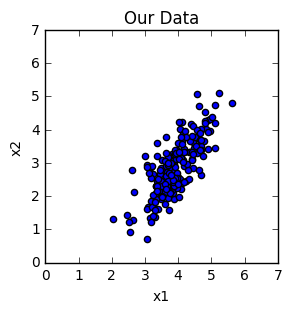

In [23]:
fig = plt.figure(figsize=(3,3))
plt.scatter(data[0,:], data[1,:])
plt.xlim(0,7), plt.ylim(0,7)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Our Data')
plt.show()

#### 2.2 Compute the data's mean and covariance matrix

Given the data $\{\texttt{x}_n\}$, its mean $\overline{\texttt{x}}$ and covariance matrix $\textbf{S}$ are computed according to:
$$\overline{\texttt{x}} = \frac{1}{N}\sum_{n=1}^N \texttt{x}_n, 
\hspace{1cm} \textbf{S} = \frac{1}{N}\sum_{n=1}^N (\texttt{x}_n - \overline{\texttt{x}})(\texttt{x}_n - \overline{\texttt{x}})^\texttt{T}  $$

In [29]:
#Data mean
data_mean = np.mean(data, axis=1).reshape(-1,1)

#Data covariance matrix (you can use np.cov(data))
S = []
for point in data.T:
    diff = point - data_mean.T
    S.append(np.dot(diff.T,diff))
S = np.mean(S, axis=0)

print("Data mean (centroid):\n", data_mean)
print("Data covariance matrix:\n",S)

print("\nCompare to the ones used for generating the data:")
print("Chosen mean:\n", mean)
print("Chosen covariance matrix:\n", np.matrix(cov))

Data mean (centroid):
 [[ 3.89627454]
 [ 2.85136534]]
Data covariance matrix:
 [[ 0.34351645  0.37475183]
 [ 0.37475183  0.68847741]]

Compare to the ones used for generating the data:
Chosen mean:
 [4, 3]
Chosen covariance matrix:
 [[ 0.4   0.45]
 [ 0.45  0.8 ]]


___
### 3. Maximum variance formulation

**Goal**: Find the principal direction (vector $\textbf{u}_1$) onto which the variance of the projected data is maximized.

We're only interested in the direction $\textbf{u}_1$, so we can choose it to be an unit vector ($\textbf{u}_1^\texttt{T}\textbf{u}_1 = 1$) without loss of generality. 

Then, each data point $\texttt{x}_n$ is projected onto a esclar given by $\textbf{u}_1^\texttt{T}\texttt{x}_n$. In the end, the mean of all projections (scalars) is equivalent to the projection of the data mean, given by $\textbf{u}_1^\texttt{T}\overline{\texttt{x}}$.

Now, the variance (what we want to **maximize**) is given by:
$$
variance = \frac{1}{N}\sum_{n=1}^N (\textbf{u}_1^\texttt{T}\texttt{x}_n - \textbf{u}_1^\texttt{T}\overline{\texttt{x}})^2 = 
\textbf{u}_1^\texttt{T}\textbf{S}\textbf{u}_1
$$
Note that the variance of the **projected data** can also be given in terms of the covariance matrix ($\textbf{S}$) of the **original data**, defined [here](#2.2-Compute-the-data's-mean-and-covariance-matrix).

#### 3.1 Defining function to be optimized

So far, we want to find the vector $\textbf{u}_1$ which maximizes the variance $\textbf{u}_1^\texttt{T}\textbf{S}\textbf{u}_1$. Note that if we'd allow the magnitude of $\textbf{u}_1$ to increase, the variance would as well and the maximization would lead to $\Vert\textbf{u}_1\Vert\rightarrow\infty$. In order to to prevent that, this has to be a **constrained maximization**. The appropriate constraint is the normalization condition $\textbf{u}_1^\texttt{T}\textbf{u}_1 = 1$, which is enforced by introducing a Lagrange multiplier $\lambda_1$. We can then make an **unconstrained maximization** of

$$
\mathcal{L}(\textbf{u}_1,\lambda_1) = \textbf{u}_1^\texttt{T}\textbf{S}\textbf{u}_1 + \lambda_1\left(1 - \textbf{u}_1^\texttt{T}\textbf{u}_1\right).
$$

Now, $\mathcal{L}(\textbf{u}_1,\lambda_1)$ can be maximized with respect to $\textbf{u}_1$, by setting its derivative to zero:

$$ \frac{\partial\mathcal{L}(\textbf{u}_1,\lambda_1)}{\partial\textbf{u}_1} = 0 $$ 
$$
\frac{\partial}{\partial\textbf{u}_1}\left[\textbf{u}_1^\texttt{T}\textbf{S}\textbf{u}_1 + \lambda_1\left(1 - \textbf{u}_1^\texttt{T}\textbf{u}_1\right)\right] = 0
$$
$$
\frac{\partial}{\partial\textbf{u}_1}\left[\textbf{u}_1^\texttt{T}\textbf{S}\textbf{u}_1\right] + \frac{\partial}{\partial\textbf{u}_1}\left[\lambda_1\left(1 - \textbf{u}_1^\texttt{T}\textbf{u}_1\right)\right] = 0
$$
$$
\textbf{u}_1^\texttt{T}\left(\textbf{S}+\textbf{S}^\texttt{T}\right) - \lambda_1\textbf{u}_1^\texttt{T}\left(\textbf{I}+\textbf{I}^\texttt{T}\right) = 0 
$$
$$\textbf{u}_1^\texttt{T}\textbf{S} = \lambda_1\textbf{u}_1^\texttt{T}$$
$$\textbf{S}\textbf{u}_1 = \lambda_1\textbf{u}_1$$

In the derivation above, the $\textbf{S}$ matrix's symmetry was used. 

Finally, the last equality shows us that, in order to maximize the variance, $\textbf{u}_1$ must be an eigenvector of $\textbf{S}$, with a correspondent eigenvalue equal to $\lambda_1$. The last equality can also be rearranged to $\textbf{u}_1^\texttt{T}\textbf{S}\textbf{u}_1 = \lambda_1$, which equals the $variance$! The vector $\textbf{u}_1$ is the **first principal component** of the data. 

> **Summing up:** The variance of the projected data is maximized if the projection is performed along the direction of the covariance matrix's eigenvector that is coupled with the its largest eigenvalue. By doing so, the projected data's variance equals that eigenvalue, and it's the higher variance you can get. 


#### 3.2 Computing the principal components

In [120]:
eig_values,eig_vectors = np.linalg.eig(S)     #Get the eigenvectors and eigenvalues of S
print("Eigenvalues = ", eig_values)
print("Eigenvectors = ", eig_vectors, "\n")
        
u1 = eig_vectors[:,eig_values.argmax()].reshape(-1,1)     #Get the eigenvector that is coupled with the largest eigenvalue
u2 = eig_vectors[:,eig_values.argmin()].reshape(-1,1)     #The second principal component is the one with the smallest eigenvalue

u1 = u1 if u1[1,0]>0 else -u1                 #This forces the phase of u1 between 0 and 180º (Not really needed)
u2 = u2 if u2[1,0]>0 else -u2 

print("u1 =", u1)
print("u2 = ", u2)

Eigenvalues =  [ 0.1034579   0.92853596]
Eigenvectors =  [[-0.84204957 -0.53940015]
 [ 0.53940015 -0.84204957]] 

u1 = [[ 0.53940015]
 [ 0.84204957]]
u2 =  [[-0.84204957]
 [ 0.53940015]]


#### 3.3 Plotting the data, along with its principal components

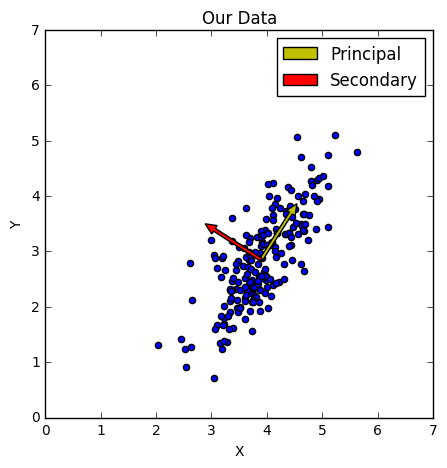

In [121]:
fig = plt.figure(figsize=(5,5))
plt.scatter(data[0,:], data[1,:], label="Data")
plt.xlim(0,7), plt.ylim(0,7)
plt.xlabel('X'),plt.ylabel('Y')
plt.title('Our Data')

#Let's add arrows to represent the principal components. We can center the arrows over the data's centroid (data_mean).
arrow1 = plt.arrow(data_mean[0,0], data_mean[1,0], u1[0,0], u1[1,0], width=0.06, head_width=0.18, head_length=0.2, fc='y', ec='k')
arrow2 = plt.arrow(data_mean[0,0], data_mean[1,0], u2[0,0], u2[1,0], width=0.06, head_width=0.18, head_length=0.2, fc='r', ec='k')
plt.legend([arrow1,arrow2], ['Principal','Secondary'])
plt.show()

#### 3.4 Project the data onto u1, compute the variance and plot

We know that if we project the data onto $\textbf{u}_1$ we get the largest variance, which equals the largest eigenvalue of $\textbf{S}$. 

Let's verify that by computing the variance of the projected data, which can be done in two manners.

In [84]:
#Computing the variance using the data per se
projected_data = [np.dot(u1.T,v) for v in data.T]
projected_data_mean = np.dot(u1.T,data_mean)
projected_data_var = np.mean([(v - projected_data_mean)**2 for v in projected_data])

#Compute the variance using S
projected_data_var_ = (u1.T*S*u1)[0,0]

print("Projected data variance =", projected_data_var)
print("Same variance using S   =", projected_data_var_)
print("As expected, the variance is equal to the largest eigenvalue:", eig_values.max())

Projected data variance = 0.928535956198
Same variance using S   = 0.09994697705
As expected, the variance is equal to the largest eigenvalue: 0.928535956198


 Now let's plot the projected data along the first principal component.

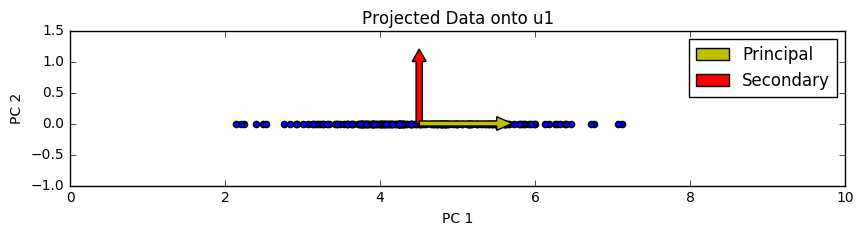

In [85]:
fig = plt.figure(figsize=(10,2))
plt.scatter(projected_data, np.zeros(len(projected_data)), label="Data")
arrow2 = plt.arrow(projected_data_mean, 0, 0, 1, width=0.08, head_width=0.18, head_length=0.2, fc='r', ec='k')
arrow1 = plt.arrow(projected_data_mean, 0, 1, 0, width=0.08, head_width=0.22, head_length=0.2, fc='y', ec='k')
plt.xlim(0,10), plt.ylim(-1,1.5)
plt.xlabel('PC 1'),plt.ylabel('PC 2')
plt.legend([arrow1,arrow2], ['Principal','Secondary'])
plt.title('Projected Data onto u1')
plt.show()

#### 3.4 [Extra] Plot the variance against different  vector directions

As already proved, $\textbf{u}_1$ is the vector which maximizes the variance. For this simple example, we can observe how the variance changes if we project the data along different directions.

Maximum is = 0.9285 for an angle of = 57.4°
Again, we have the same results! u1 has an angle of 57.4°


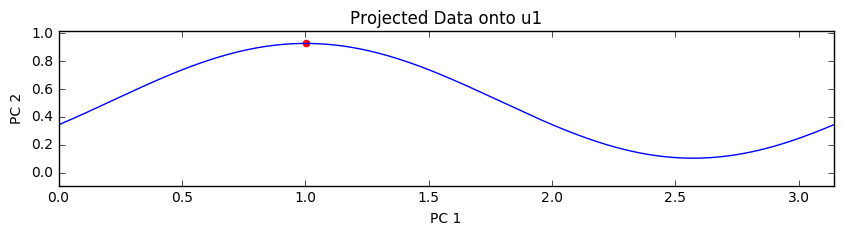

In [119]:
angles = np.arange(0, np.pi, 0.001)          #Let's compute the variance for angles varying from 0° to 180°

var_by_angle = []
for angle in angles:
    u = np.array([np.cos(angle), np.sin(angle)]).reshape(-1,1)
    var_ = u.T.dot(S).dot(u)[0,0]
    var_by_angle.append(var_)

max_var = np.max(var_by_angle)                                #Get the maximum  variance
max_var_angle = angles[np.argmax(var_by_angle)]*180/np.pi     #Get the angle for maximum variance

print("Maximum is = {0:.4f} ".format(max_var), end='')
print("for an angle of = {0:.1f}\u00b0".format(max_var_angle))
print("Again, we have the same results! u1 has an angle of {0:.1f}\u00b0".format(np.arctan2(u1[1,0], u1[0,0])*180/np.pi))

fig = plt.figure(figsize=(10,2))
plt.plot(angles,var_by_angle)
plt.scatter(angles[np.argmax(var_by_angle)], max_var, color='r')
plt.xlim(0,np.pi), plt.ylim(-0.1*max_var, 1.1*max_var)
plt.xlabel('PC 1'),plt.ylabel('PC 2')
plt.title('Projected Data onto u1')
plt.show()

### 4. Minimum-error formulation

Originally, our data has _D_ dimensions, since each sample is described by _D_ coordinates. Despite the original _D_ axes, we can always represent the same data in a different _D-dimensional_ basis, i.e., in a different frame. 

Firstly, we're looking for a specific orthonormal set of D-dimensional basis vectors $\{\textbf{u}_i\}$ on which we can describe our data. They are orthonormal, therefore satisfying $\textbf{u}_i^\texttt{T}\textbf{u}_j = \delta_{ij}$. Also, since this basis is complete, the vectors span the whole _D-dimensional_ space, which means that any vector can be expressed as a linear combination of them: 
$$
\textbf{x}_n = \sum_{i=1}^D \alpha_{ni}\textbf{u}_i, \hspace{1cm} \alpha_{ni} = \textbf{x}_n^\texttt{T}\textbf{u}_i, \hspace{1cm}\textbf{x}_n = \sum_{i=1}^D (\textbf{x}_n^\texttt{T}\textbf{u}_i)\textbf{u}_i,
$$
As shown above, the scalar $\alpha_{ni}$ is the projection of the n-th vector onto the i-th basis vector.

So far, no dimensionaly reduction was done, we simply rotated the data. However, the idea is to try to represent that data using _M_ dimensions (_M < D_), but keeping as much information as possible. If the rotation is done properly, information might end up concentrated along a smaller number of dimensions. To ignore the other _D-M_ dimensions, we can set their coefficients to be the same for all the data.
$$
\textbf{x}_n = \sum_{i=1}^M \alpha_{ni}\textbf{u}_i + \sum_{i=M+1}^D \alpha_{ni}\textbf{u}_i
$$
$$
\tilde{\textbf{x}}_n = \sum_{i=1}^M z_{ni}\textbf{u}_i + \sum_{i=M+1}^D b_i\textbf{u}_i
$$

Note that the second summation on $\tilde{\textbf{x}}_n$ represent all dimensions we are discarding. Now, we define a cost function _J_ to be minimized, as follows:
$$
J = \frac{1}{N}\sum_{i=1}^N \Vert \textbf{x}_n - \tilde{\textbf{x}}_n\Vert^2
$$

**Goal:** find the orthonormal basis whose vectors in this approach, we want to minimize the data projection error. Originally, The idea is to find a set of D-dimensional basis vectors $\{\textbf{u}_1\}$

___
### 5. References

[1] Bishop, Christopher M. Pattern recognition and machine learning. springer, 2006.